In [1]:
# Imports

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import random

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats

In [2]:
#Reading In and Cleaning Raw Data

In [4]:
#Reading in data and making arrays

data = pd.read_csv('dataGaia.csv')

#Panda 'Arrays' to Numpy Arrays
#temperature
TempPd = data['Teff']
Temp_raw = []
for i in TempPd:
    Temp_raw.append(i)
#luminosity
LumPd = data['Lum-Flame']
Lum_raw = []
for i in LumPd:
    Lum_raw.append(i)

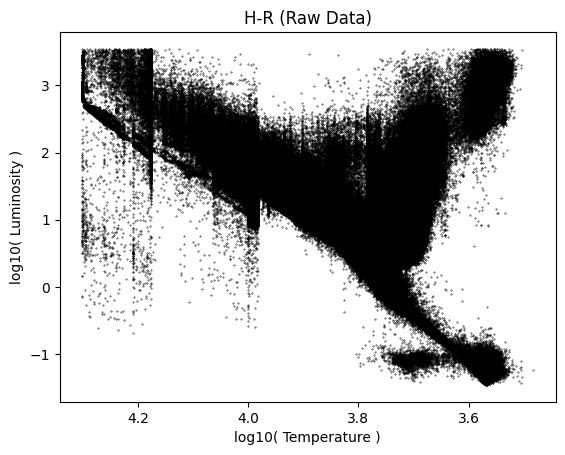

In [5]:
#H-R Graph with raw data

Temp_raw_log10 = np.log10(Temp_raw)
Lum_raw_log10 = np.log10(Lum_raw)

plt.scatter(Temp_raw_log10, Lum_raw_log10, s = 0.1, c = 'black')
plt.xlabel("log10( Temperature )")
plt.ylabel("log10( Luminosity )")
plt.title("H-R (Raw Data)")
plt.gca().invert_xaxis()

In [6]:
#Clean Values - ignore NaN values in Luminosity

Temp = []
Lum = []

ugly = 0
for i in range(len(Lum_raw)):
    if np.isnan(Lum_raw[i]):
        ugly = 0
    else:
        Temp.append(Temp_raw[i])
        Lum.append(Lum_raw[i])

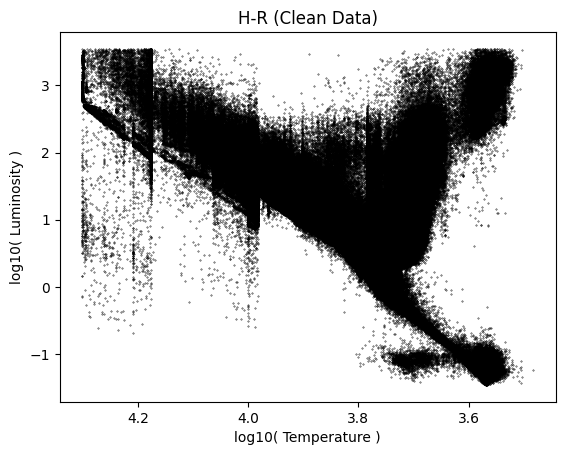

In [8]:
#Regraph H-R with 'clean' Luminosity - looks the same

Temp_log10 = np.log10(Temp)
Lum_log10 = np.log10(Lum)

plt.scatter(Temp_log10, Lum_log10, s = 0.1, c = 'black')
plt.xlabel("log10( Temperature )")
plt.ylabel("log10( Luminosity )")
plt.title("H-R (Clean Data)")
plt.gca().invert_xaxis()

In [13]:
#Minimizing Data - 10x reduction in size.
#This is not needed, just to make code run faster

size = 60000

Temp_log10_simp = []
Lum_log10_simp = []

for i in range(size):
    run = np.random.randint(0, len(Temp_log10) - 1)
    Temp_log10_simp.append(Temp_log10[run])
    Lum_log10_simp.append(Lum_log10[run])

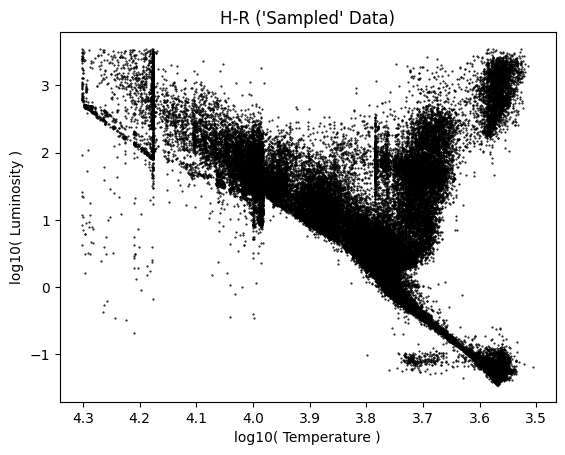

In [14]:
#Regraph with smaller dataset

plt.scatter(Temp_log10_simp, Lum_log10_simp, s = 0.25, c = 'black')
plt.xlabel("log10( Temperature )")
plt.ylabel("log10( Luminosity )")
plt.title("H-R ('Sampled' Data)")
plt.gca().invert_xaxis()

In [15]:
#Clustering

In [16]:
#Set data array (log10(temp) vs log10(lum))

TL = np.vstack([Temp_log10, Lum_log10]).T
TL_simp = np.vstack([Temp_log10_simp, Lum_log10_simp]).T   #smaller data

In [118]:
#Compute the K-means Clustering

def ClustIndNum(clustNum, labels_array):
    return np.where(labels_array == clustNum)[0]
colors_map = ['black', 'blue', 'red', 'yellow', 'purple', 'orange', 'green', 'grey', 'pink', 'brown', 'cyan', 'olive']

def K_Means_Clustering(clust_num, just_one):

    for i in range(clust_num):

        if just_one == 1:
            n_clusters_km = clust_num
        else:
            n_clusters_km = i + 1
            
        scaler = preprocessing.StandardScaler()
        km = KMeans(n_clusters_km)
        km.fit(scaler.fit_transform(TL))

        #Ignore
        labels_unique_km = np.unique(km.labels_)
        #print(labels_unique_km)
        print("Clusters:", n_clusters_km)

        # Make some plots
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot()

        # Compute a 2D histogram  of the input
        H_km, xedges_km, yedges_km = np.histogram2d(TL[:,0], TL[:,1], 50)

        # plot density
        ax.imshow(H_km.T, origin = 'lower', interpolation = 'nearest', aspect = 'auto', extent = [xedges_km[0], xedges_km[-1], yedges_km[0], yedges_km[-1]], cmap = 'Blues')

        # plot cluster centers
        cluster_centers_km = scaler.inverse_transform(km.cluster_centers_)
        ax.scatter(cluster_centers_km[:, 0], cluster_centers_km[:, 1], s = 40, c = 'w', edgecolors = 'k')

        # plot cluster boundaries
        x_centers_km = 0.5 * (xedges_km[1:] + xedges_km[:-1])
        y_centers_km = 0.5 * (yedges_km[1:] + yedges_km[:-1])

        Xgrid_km = np.meshgrid(x_centers_km, y_centers_km)
        Xgrid_km = np.array(Xgrid_km).reshape((2, 50 * 50)).T

        H_km = km.predict(scaler.transform(Xgrid_km)).reshape((50, 50))

        for i in range(n_clusters_km):
            Hcp = H_km.copy()
            flag = (Hcp == i)
            Hcp[flag] = 1
            Hcp[~flag] = 0

            ax.contour(x_centers_km, y_centers_km, Hcp, [-0.5, 0.5], linewidths = 1, colors = 'k')

            H_km = km.predict(scaler.transform(Xgrid_km)).reshape((50, 50))
            
        ax.set_xlim(xedges_km[0], xedges_km[-1])
        ax.set_ylim(yedges_km[0], yedges_km[-1])
        ax.set_xlabel("log10( Temperature )")
        ax.set_ylabel("log10( Luminosity )")
        plt.title("H-R (K - Means)   Clusters:" + str(n_clusters_km))

        #Ignore Later (Graphing Data With Colors)
        def ClustGraphData_km(cluster):
            for j in range(cluster):
                plt.scatter(TL[ClustIndNum(j, km.labels_)][:,0], TL[ClustIndNum(j, km.labels_)][:,1], s = 0.25, c = colors_map[j])     #with colors
                #plt.scatter(TL[ClustIndNum(j, km.labels_)][:,0], TL[ClustIndNum(j, km.labels_)][:,1], s = 0.25, c = 'blue')             #with no colors
        ClustGraphData_km(n_clusters_km)
        plt.xlim(3.5, 4.3)
        plt.ylim(-1.5, 3.5)

        plt.gca().invert_xaxis()
        plt.show()

        if just_one == 1:
            return km
            break

Chosen number of clusters:
Clusters: 10


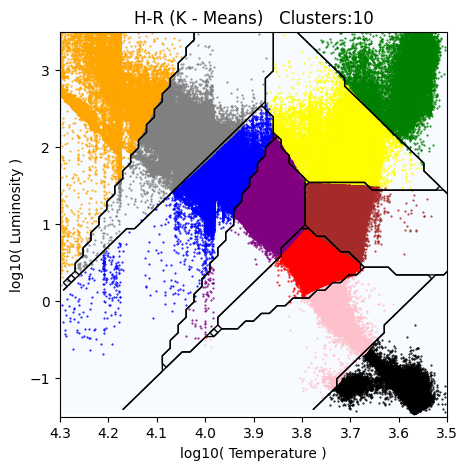

KMeans(n_clusters=10)

In [119]:
#Graph for all number of clusters or just the final

#K_Means_Clustering(11, 0)
print("Chosen number of clusters:")
K_Means_Clustering(10, 1)

In [33]:
#Redefine km

chosen_number = 10

scaler = preprocessing.StandardScaler()
km = KMeans(chosen_number)
km.fit(scaler.fit_transform(TL))

KMeans(n_clusters=10)

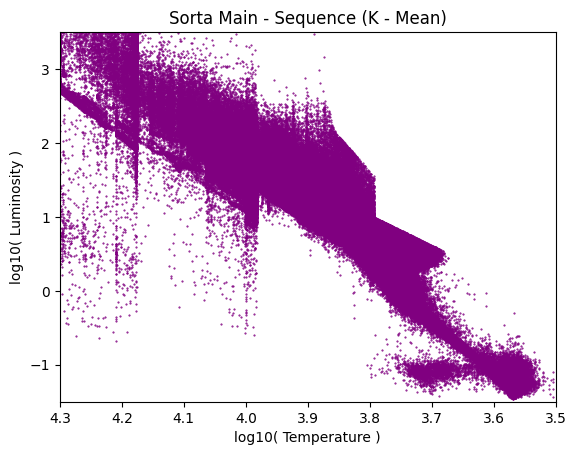

In [74]:
#Making "Main-Sequence" array by manually selecting clusters ^
# this is basically using the prior knowledge that the main sequence does not contain the portion in the top right

MS_clusters = [0, 1, 3, 4, 6, 7, 8]    #this is filled out manually, leaving out the clusters in the top right

MS_x = []
MS_y = []

for clust in MS_clusters:
    for i in TL[ClustIndNum(clust, km.labels_)][:,0]:
        MS_x.append(i)
    for j in TL[ClustIndNum(clust, km.labels_)][:,1]:
        MS_y.append(j)

plt.scatter(MS_x, MS_y, s = 0.25, c = 'purple')
plt.xlabel("log10( Temperature )")
plt.ylabel("log10( Luminosity )")
plt.title("Sorta Main - Sequence (K - Mean)")
plt.xlim(3.5, 4.3)
plt.ylim(-1.5, 3.5)
plt.gca().invert_xaxis()

In [423]:
#Best Fit

In [95]:
#Define Chi Squared

dy = []
for i in MS_y:
    dy.append(0.1)

x = np.array(MS_x)
y = np.array(MS_y)

# Chi Squared function
def squared_loss(m, b, x, y, dy):
    y_fit = (m * x) + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

f_squared = lambda chi2: squared_loss(chi2[0], chi2[1], x = x, y = y, dy = dy)

# Maximum likelihood (Chi Squared)
chi20 = (1, 100) # initial guess
chi_squared = optimize.fmin(f_squared, chi20)

Optimization terminated successfully.
         Current function value: 5506715.422770
         Iterations: 79
         Function evaluations: 149


In [ ]:
#Log-likelihood via the Huber loss function

def huber_loss(m, b, x, y, dy, c = 2):
    y_fit = m * x + b
    t = abs((y - y_fit) / dy)
    mask = t > c
    return np.sum((~mask) * (0.5 * (t ** 2)) - ((mask) * c * (0.5 * c - t)), -1)

f_huber = lambda beta: huber_loss(beta[0], beta[1], x = x, y = y, dy = dy, c = 1)

beta0 = (1, 30)
beta_huber = optimize.fmin(f_huber, beta0)

Optimization terminated successfully.
         Current function value: 972840.605374
         Iterations: 73
         Function evaluations: 140


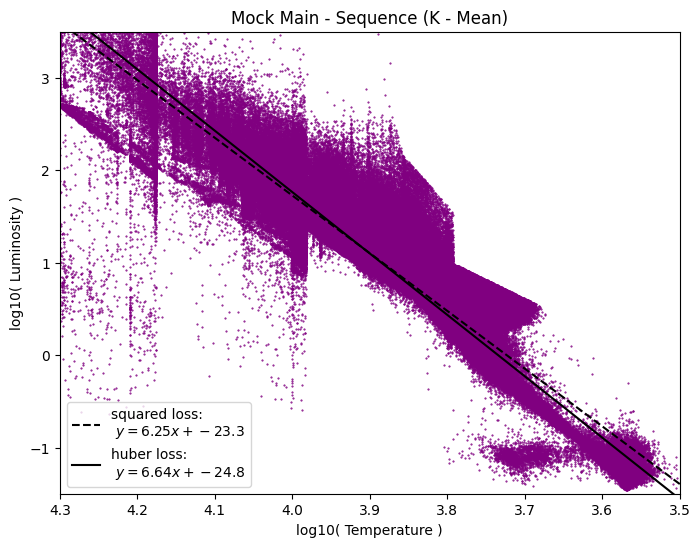

In [91]:
# Plot the results

x_fit = np.linspace(3.5, 4.3, 10)
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

#plot the data (main sequence)
plt.scatter(MS_x, MS_y, s = 0.25, c = 'purple')
plt.xlabel("log10( Temperature )")
plt.ylabel("log10( Luminosity )")
plt.title("Mock Main - Sequence (K - Mean)")

# chi squared
ax.plot(x_fit, chi_squared[0] * x_fit + chi_squared[1], ls = '--', color='black', label = "squared loss:\n $y=%.2fx + %.1f$" % tuple(chi_squared))
# hubber
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], ls = '-', color='black', label = "huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))

ax.legend(loc = 3, prop = dict(size = 10))
plt.xlim(3.5, 4.3)
plt.ylim(-1.5, 3.5)
plt.gca().invert_xaxis()

In [92]:
#Chi Squared

N_chi = x.shape[0]
k = 2 

chi2 = squared_loss(chi_squared[0], chi_squared[1], x = x, y = y, dy = dy)
chi2dof = chi2 / (N_chi - k)

print(chi2dof - 1, np.sqrt(2 / (N_chi - k)))
print("")
bill = (chi2dof - 1) / (np.sqrt(2 / (N_chi - k)))
print(bill)     #want this to be low - it is not. This is not a very good estimation

10.84497153740954 0.002074128656526349

5228.687961706376


In [ ]:
#Loss Functions

# Squared loss function
lnL_sq = - squared_loss(chi_squared[0], chi_squared[1], x = x, y = y, dy = dy)

# Huber loss function
lnL_huber = - huber_loss(beta_huber[0], beta_huber[1], x = x, y = y, dy = dy)

#want these to be low - they are not. These are not very good estimations - makes sense
print("Maximum log likelihood for squared loss = %.1f" % lnL_sq)
print("Maximum log likelihood for Huber loss = %.1f" % lnL_huber)

Maximum log likelihood for squared loss = -5506715.4
Maximum log likelihood for Huber loss = -1598871.6


In [102]:
#Converting Clusters to Points (average)

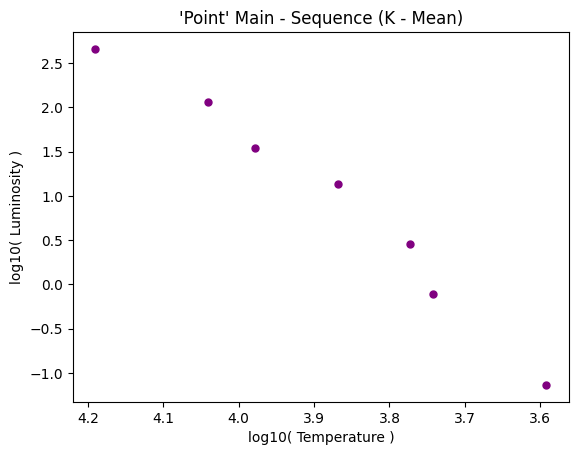

In [110]:
#Plotting "Point" Clusters

MS_x_point = []
MS_y_point = []

for clust in MS_clusters:
    #taking average of clusters to make them each a single point (temp)
    ms_x_temp = []
    ms_y_temp = []
    for i in TL[ClustIndNum(clust, km.labels_)][:,0]:
        ms_x_temp.append(i)
    for j in TL[ClustIndNum(clust, km.labels_)][:,1]:
        ms_y_temp.append(j)
    MS_x_point.append(np.mean(ms_x_temp))
    MS_y_point.append(np.mean(ms_y_temp))
    #print("X:", MS_x_temp)
    #print("Y:", MS_y_temp)

plt.scatter(MS_x_point, MS_y_point, s = 25, c = 'purple')
plt.xlabel("log10( Temperature )")
plt.ylabel("log10( Luminosity )")
plt.title("'Point' Main - Sequence (K - Mean)")
plt.gca().invert_xaxis()

In [99]:
#Redoing Best Fit with Just Points

In [104]:
#Chi Squared

x_point = np.array(MS_x_point)
y_point = np.array(MS_y_point)

dy_point = []
for i in MS_y_point:
    dy_point.append(0.1)

f_squared_point = lambda chi2_point: squared_loss(chi2_point[0], chi2_point[1], x = x_point, y = y_point, dy = dy_point)

# Maximum likelihood (Chi Squared)
chi20_point = (1, 100) # initial guess
chi_squared_temp = optimize.fmin(f_squared_point, chi20_point)

Optimization terminated successfully.
         Current function value: 26.515296
         Iterations: 81
         Function evaluations: 153


In [105]:
#Likelihood

f_huber_point = lambda beta_point: huber_loss(beta_point[0], beta_point[1], x = x_point, y = y_point, dy = dy_point, c = 1)

beta0 = (1, 30)
beta_huber = optimize.fmin(f_huber_point, beta0)

Optimization terminated successfully.
         Current function value: 8.644099
         Iterations: 74
         Function evaluations: 141


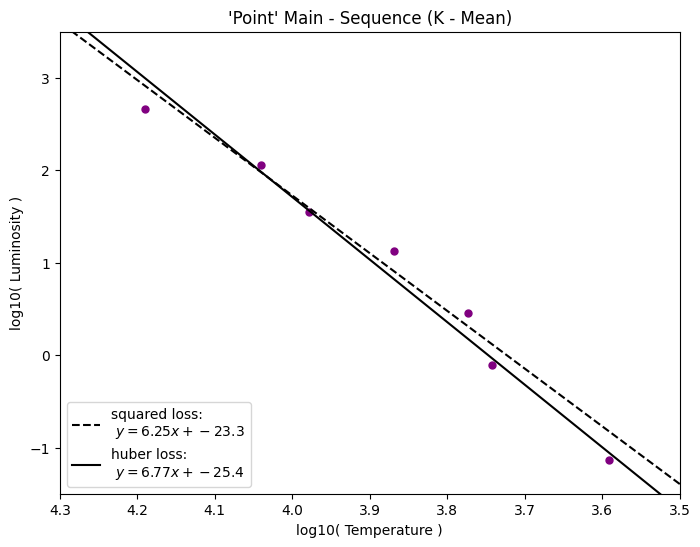

In [120]:
# Plot the results

x_fit = np.linspace(3.5, 4.3, 10)
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

#plot the data (main sequence)
plt.scatter(MS_x_point, MS_y_point, s = 25, c = 'purple')
plt.xlabel("log10( Temperature )")
plt.ylabel("log10( Luminosity )")
plt.title("'Point' Main - Sequence (K - Mean)")

# chi squared
ax.plot(x_fit, chi_squared[0] * x_fit + chi_squared[1], ls = '--', color='black', label = "squared loss:\n $y=%.2fx + %.1f$" % tuple(chi_squared))
# hubber
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], ls = '-', color='black', label = "huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))

ax.legend(loc = 3, prop = dict(size = 10))
plt.xlim(3.5, 4.3)
plt.ylim(-1.5, 3.5)
plt.gca().invert_xaxis()

In [112]:
#Chi Squared

N_chi_point = x_point.shape[0]
k = 2 

chi2_point = squared_loss(chi_squared[0], chi_squared[1], x = x_point, y = y_point, dy = dy_point)
chi2dof_point = chi2_point / (N_chi_point - k)

print(chi2dof_point - 1, np.sqrt(2 / (N_chi_point - k)))
print("")
bob = (chi2dof_point - 1) / (np.sqrt(2 / (N_chi_point - k)))
print(bob)

4.827379773880286 0.6324555320336759

7.6327576080451545


In [113]:
#Loss Functions

# Squared loss function
lnL_sq_point = - squared_loss(chi_squared[0], chi_squared[1], x = x_point, y = y_point, dy = dy_point)

# Huber loss function
lnL_huber_point = - huber_loss(beta_huber[0], beta_huber[1], x = x_point, y = y_point, dy = dy_point)

print("Maximum log likelihood for squared loss = %.1f" % lnL_sq_point)
print("Maximum log likelihood for Huber loss = %.1f" % lnL_huber_point)

Maximum log likelihood for squared loss = -29.1
Maximum log likelihood for Huber loss = -13.4


In [114]:
#When the clusters are converted to points (average of cluster), the best fit lines seem to be a far better fit.

In [ ]:
# Compute the Mean-shift Clustering _ Did this to find optimal number of clusters (used optimal bandwidth)
# this takes a very long time. Had to use simplified (smaller) data

scaler = preprocessing.StandardScaler()
bandwidth = estimate_bandwidth(TL_simp)
ms = MeanShift(bandwidth = bandwidth, bin_seeding = True, cluster_all = False)
ms.fit(scaler.fit_transform(TL_simp))

labels_unique_ms = np.unique(ms.labels_)
n_clusters_ms = len(labels_unique_ms[labels_unique_ms >= 0])
#n_clusters = len(labels_unique)
print(labels_unique_ms)
print(bandwidth)
print("number of estimated clusters :", n_clusters_ms)

[-1  0  1  2  3  4  5]
0.7009525679279639
number of estimated clusters : 6


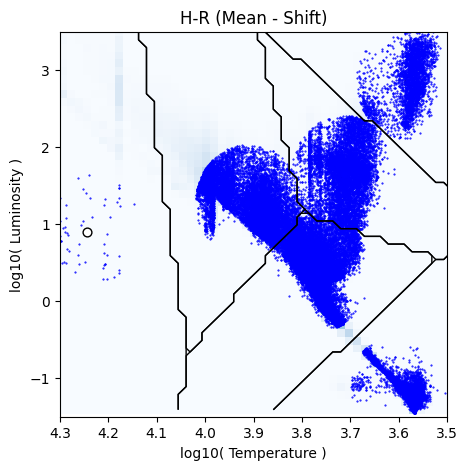

In [ ]:
#Plotting Means-Shift
# the graph did not look right, and I cannot figure out how to fix it.

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H_ms, xedges_ms, yedges_ms = np.histogram2d(TL[:,0], TL[:,1], 50)

# plot density
ax.imshow(H_ms.T, origin = 'lower', interpolation = 'nearest', aspect = 'auto', extent=[xedges_ms[0], xedges_ms[-1], yedges_ms[0], yedges_ms[-1]], cmap = 'Blues')

# plot cluster centers
cluster_centers_ms = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers_ms[:, 0], cluster_centers_ms[:, 1], s = 40, c = 'w', edgecolors = 'k')

# plot cluster boundaries
x_centers_ms = 0.5 * (xedges_ms[1:] + xedges_ms[:-1])
y_centers_ms = 0.5 * (yedges_ms[1:] + yedges_ms[:-1])

Xgrid_ms = np.meshgrid(x_centers_ms, y_centers_ms)
Xgrid_ms = np.array(Xgrid_ms).reshape((2, 50 * 50)).T

H_ms = ms.predict(scaler.transform(Xgrid_ms)).reshape((50, 50))

for i in range(n_clusters_ms):
    Hcp = H_ms.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers_ms, y_centers_ms, Hcp, [-0.5, 0.5], linewidths = 1, colors = 'k')
 
    H_ms = ms.predict(scaler.transform(Xgrid_ms)).reshape((50, 50))
    
ax.set_xlim(xedges_ms[0], xedges_ms[-1])
ax.set_ylim(yedges_ms[0], yedges_ms[-1])
ax.set_xlabel("log10( Temperature )")
ax.set_ylabel("log10( Luminosity )")
plt.title("H-R (Mean - Shift)")

#Ignore Later (Graphing Data With Colors)
def ClustGraphData_ms(cluster):
    for i in range(cluster):
        plt.scatter(TL_simp[ClustIndNum(i, ms.labels_)][:,0], TL_simp[ClustIndNum(i, ms.labels_)][:,1], s = 0.25, c = 'blue')
ClustGraphData_ms(n_clusters_ms)
plt.xlim(3.5, 4.3)
plt.ylim(-1.5, 3.5)

plt.gca().invert_xaxis()
plt.show()